# Classificação das espécies de flor (iris.csv)

# Importando Bibliotecas

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

from pyspark.ml.stat import ChiSquareTest

from pyspark.sql import SparkSession, Row

from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import col, when

from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Lendo Dataset

In [8]:
spark = SparkSession.builder.appName("dataset").getOrCreate()
spark = SparkSession.builder.appName("dataset").getOrCreate()
dataset = spark.read.csv("datasets/iris.csv", header=True).withColumn("target", #forço a classificação na colua "target"
                 when(col("species") == "setosa", 0) \
                .when(col("species") == "versicolor", 2)
                .otherwise(1)) \
    .cache()

dataset.show(5, truncate=False)

+------------+-----------+------------+-----------+-------+------+
|sepal_length|sepal_width|petal_length|petal_width|species|target|
+------------+-----------+------------+-----------+-------+------+
|5.1         |3.5        |1.4         |0.2        |setosa |0     |
|4.9         |3.0        |1.4         |0.2        |setosa |0     |
|4.7         |3.2        |1.3         |0.2        |setosa |0     |
|4.6         |3.1        |1.5         |0.2        |setosa |0     |
|5.0         |3.6        |1.4         |0.2        |setosa |0     |
+------------+-----------+------------+-----------+-------+------+
only showing top 5 rows



# Normalizando dados e condensando Features

In [9]:
#rdd.map = um "for" paralelizavel que irá percorrer todo dataset.
# Row = linha do dataframe. Crio 2 colunas (data e label). Em data, coloco o vetor denso, em label, coloco o outro
# a saída n eh um dataframe, eh um rdd, por isso devo colocar "toDF" (to dataframe)
data_vector = dataset.rdd.map(lambda row: Row(data=Vectors.dense(row[0], row[1], row[2], row[3]), label=row[5])).toDF()

#normalização, transform direto
normalizer = Normalizer(inputCol="data", outputCol="features", p=1.0)
features = normalizer.transform(data_vector).drop("data")
features.show(5, truncate=False)

+-----+---------------------------------------------------------------------------------+
|label|features                                                                         |
+-----+---------------------------------------------------------------------------------+
|0    |[0.5,0.3431372549019608,0.13725490196078433,0.019607843137254905]                |
|0    |[0.5157894736842106,0.3157894736842105,0.14736842105263157,0.021052631578947368] |
|0    |[0.5,0.3404255319148936,0.13829787234042554,0.02127659574468085]                 |
|0    |[0.4893617021276596,0.3297872340425532,0.15957446808510642,0.021276595744680854] |
|0    |[0.4901960784313726,0.35294117647058826,0.13725490196078433,0.019607843137254905]|
+-----+---------------------------------------------------------------------------------+
only showing top 5 rows



# Aplicando PCA

In [10]:
#Ajuda a analisar as features mais relevantes
r = ChiSquareTest.test(features, "features", "label").head()
print("pValues: " + str(r.pValues)) #explica de novo pls
print("degreesOfFreedom: " + str(r.degreesOfFreedom)) #Grau de variância de cada Feature
print("statistics: " + str(r.statistics)) #indica a representação estatística da feature

pValues: [0.08703503703198168,0.17423291097211524,0.10124397458681877,0.04665593652898303]
degreesOfFreedom: [268, 278, 270, 254]
statistics: [300.0,299.99999999999994,300.0,293.00000000000045]


In [11]:
#Aplicando PCA para selecionar 2 features mais relevantes para tratamento
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

In [12]:
model = pca.fit(features)

In [13]:
result = model.transform(features).select("pcaFeatures", "label")
result.show(5, truncate=False)

+------------------------------------------+-----+
|pcaFeatures                               |label|
+------------------------------------------+-----+
|[-0.2938612643550726,0.20898501242973064] |0    |
|[-0.27667402717611567,0.23612672928973188]|0    |
|[-0.2910616967793551,0.20993829502190178] |0    |
|[-0.2671665469594165,0.21045443456887566] |0    |
|[-0.295985666948637,0.19644191631524746]  |0    |
+------------------------------------------+-----+
only showing top 5 rows



# Extraindo Novos Vetores de Análise

In [14]:
def extract(row):
    return (row.label, ) + tuple(row.pcaFeatures.toArray().tolist())

 #"toArray(): Separa as coluninhas de result em duas colunas diferentes"

data_frame = result.rdd.map(extract).toDF(["label", "Fx", "FY"])
data_frame.show(5, truncate=False)

+-----+--------------------+-------------------+
|label|Fx                  |FY                 |
+-----+--------------------+-------------------+
|0    |-0.2938612643550726 |0.20898501242973064|
|0    |-0.27667402717611567|0.23612672928973188|
|0    |-0.2910616967793551 |0.20993829502190178|
|0    |-0.2671665469594165 |0.21045443456887566|
|0    |-0.295985666948637  |0.19644191631524746|
+-----+--------------------+-------------------+
only showing top 5 rows



In [15]:
X = np.array(data_frame.select("Fx", "FY").collect()).astype(np.float)
Y = np.array(data_frame.select("label").collect()).ravel().astype(np.float)
print(X.shape)
print(Y.shape)

(150, 2)
(150,)


# Plotando Dados na nova "Vetorização"

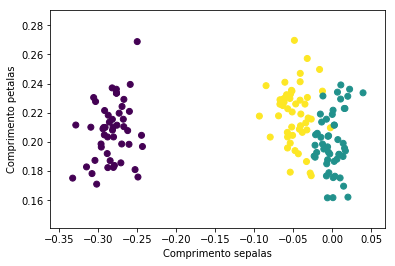

In [16]:
#Formato entrada
#to pandas
#Gráfico do tipo Pontos de Dispersão
plt.scatter(X[:, 0], #pego toda primeira coluna (correspondente ao Comprimento de "sepalas")
            X[:, 1], #pego toda primeira coluna (correspondente ao Comprimento de "petalas")
            c=Y) #atribuindo cores

#Nomeando parâmetros do plot
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

# Normalizando dados pós PCA

In [17]:
#rdd.map = um "for" paralelizavel que irá percorrer todo dataset.
# Row = linha do dataframe. Crio 2 colunas (data e label). Em data, coloco o vetor denso, em label, coloco o outro
# a saída n eh um dataframe, eh um rdd, por isso devo colocar "toDF" (to dataframe)
data_vector = data_frame.rdd.map(lambda row: Row(data=Vectors.dense(row[1], row[2]), label=row[0])).toDF()

#normalização, transform direto
normalizer = Normalizer(inputCol="data", outputCol="features", p=1.0)
features = normalizer.transform(data_vector).drop("data")
features.show(5, truncate=False)

+-----+-----------------------------------------+
|label|features                                 |
+-----+-----------------------------------------+
|0    |[-0.5843958241751738,0.41560417582482634]|
|0    |[-0.5395351385261502,0.4604648614738498] |
|0    |[-0.5809614801247686,0.4190385198752315] |
|0    |[-0.5593693687922517,0.4406306312077483] |
|0    |[-0.6010745072134246,0.3989254927865753] |
+-----+-----------------------------------------+
only showing top 5 rows



# Aplicar Algorítmo de Classificação

In [18]:
(train, test) = features.randomSplit([0.65, 0.35], seed = 10)

In [19]:
#número de camadas: 3 neuronios de entrada, 7 na camada intermediaria e 3 na saída
mlp = MultilayerPerceptronClassifier(layers=[2, 7, 3])
pipeline = Pipeline(stages=[mlp])

model = pipeline.fit(train)
predictions = model.transform(test)

In [20]:
predictions = predictions.select('features', 'prediction', 'label')
predictions.show(5, truncate=False)

+-----------------------------------------+----------+-----+
|features                                 |prediction|label|
+-----------------------------------------+----------+-----+
|[-0.6383949750092655,0.3616050249907346] |0.0       |0    |
|[-0.6333156663491332,0.3666843336508669] |0.0       |0    |
|[-0.6033789712465593,0.39662102875344074]|0.0       |0    |
|[-0.6029784990650995,0.3970215009349006] |0.0       |0    |
|[-0.6003356080020977,0.3996643919979022] |0.0       |0    |
+-----------------------------------------+----------+-----+
only showing top 5 rows



# Avaliando Modelo

In [21]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Accuracy = " + str(evaluator.evaluate(predictions)))

Accuracy = 0.9661016949152542


In [22]:
data = np.array(predictions.collect())
pd.crosstab(data[:,1], data[:,2])

col_0,0,1,2
row_0,,,
0.0,20,0,0
1.0,0,15,2
2.0,0,0,22
